In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "16"
os.environ["NUMEXPR_NUM_THREADS"] = "16"
os.environ["OMP_NUM_THREADS"] = "16"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from abtem import *

import scipy.constants as c
from abtem.reconstruct import invms

from abtem.custom import semiangle_2_sampling_extent,semiangle_gpts_2_extent
from abtem.scan import PositionScan

import cupy as cp
import h5py
import pathlib

import matplotlib
from abtem.custom import incoherent_probe, get_probe_radius
from ase.build import nanotube
from abtem.custom import crop
from abtem.noise import poisson_noise
from ase.build import graphene
from abtem.structures import orthogonalize_cell


In [3]:
def get_positions(scan_gpts,extent,scan_sampling):
    scan_start = extent/2-scan_sampling*(scan_gpts-1)/2
    scan_end = scan_start+scan_sampling*(scan_gpts) # although wrong it works so that extent/2 is where cetnral scan is. 
    scan_grid = GridScan(scan_start, scan_end, sampling = scan_sampling)
    positions = scan_grid.get_positions()
    return(positions)


In [4]:
def get_potential_from_atoms(atoms_in, extent, sampling):
    atoms=atoms_in.copy()
    vacuum_offset=0
    atoms.center(vacuum=0)
    atoms_extent=atoms.cell.diagonal() #x,y,z
    
    vacuum=(extent-atoms_extent)/2 #x,y,z
    atoms.center(vacuum=vacuum[0]+vacuum_offset,axis=(0))
    atoms.center(vacuum=vacuum[1]+vacuum_offset,axis=(1))

    atoms.center(vacuum=2,axis=(2))

    potential = Potential(FrozenPhonons(atoms, sigmas=0.06, num_configs=1), #atoms_p,
                      sampling=sampling,
                      slice_thickness=2,
                      projection='infinite',
                      parametrization='kirkland')
    return(atoms,potential)

In [5]:
energy = 30e3
px_size = 56e-6
px_num = 256
#camera_length = 240e-3
#angular_sampling = px_size/camera_length*1e3 # in mrad
angular_semiextent = 60#angular_sampling * px_num / 2
                                                                                                                                                                                                                                                                                                                               
binning = 1
reciprocal_oversampling = 1
direct_oversampling = 4
sampling,extent = semiangle_2_sampling_extent(angular_semiextent,px_num/binning,energy=energy,direct_oversampling=direct_oversampling,reciprocal_oversampling=reciprocal_oversampling)

In [6]:
semiangle_cutoff = 12.4
defocus=-400 # 0 nebo 2000
aberrations={"C30":0.88e-3/1e-10,'C50':0*0.81e-3/1e-10}
#aberrations={"C30":6021062}
temporal_sigma=0
spatial_sigma=0

probe = Probe(energy=energy, defocus=defocus, semiangle_cutoff=semiangle_cutoff,rolloff=2, **aberrations, device="gpu",sampling=sampling,extent=extent)

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fe7e20f42e0>)

<Figure size 2000x2000 with 0 Axes>

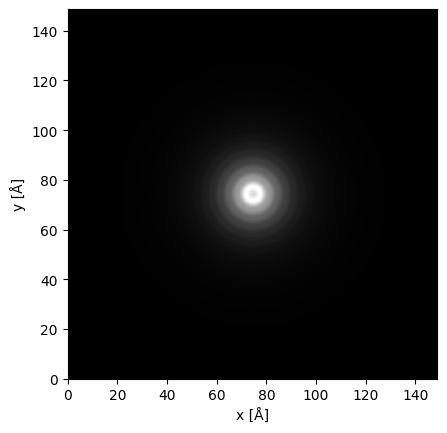

In [7]:
plt.figure(figsize=(20,20))
probe.show(power=0.5)

<Axes: xlabel='alpha [mrad]', ylabel='Envelope'>

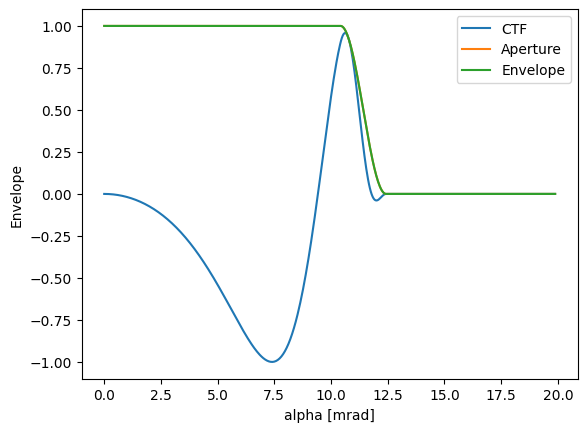

In [8]:
probe.ctf.show()

In [9]:
detector = PixelatedDetector(None)

In [10]:
from ase import Atoms

In [11]:
12e-3*1/probe.wavelength

0.1719423956114148

<Axes: xlabel='x [Å]', ylabel='y [Å]'>

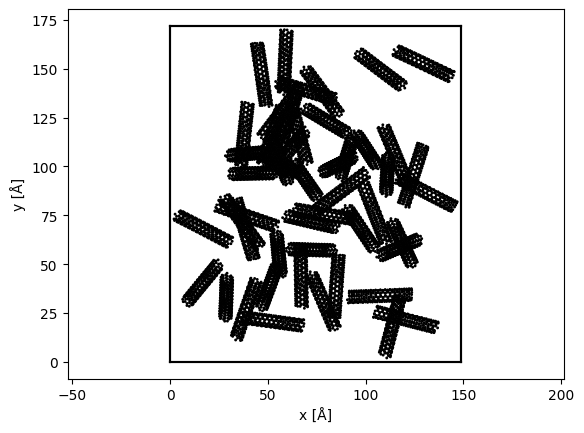

In [12]:
N=50
np.random.seed(2)
#cnt_positions=np.random.uniform(-80,80,(N,2))
cnt_positions=(np.random.beta(2.5,2.5,(N,2))-1)*2*80
cnt_rotations_y=np.random.uniform(-60,+60,N)
cnt_rotations_z=np.random.uniform(0,360,N)

atoms=Atoms()
for i in range(N):
    cnt = nanotube(5, 4, length=1)
    cnt.rotate(90+cnt_rotations_y[i],"y",center='COM')
    cnt.rotate(cnt_rotations_z[i],"z",center='COM')
    cnt.center(vacuum=1,about=0)
    cnt.translate(np.array([*cnt_positions[i],0]))
    atoms += cnt
atoms.center(vacuum=2)
show_atoms(atoms,plane="xy")

/tmp/ipykernel_4068654/22124836.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  atoms *= (24,16,1)


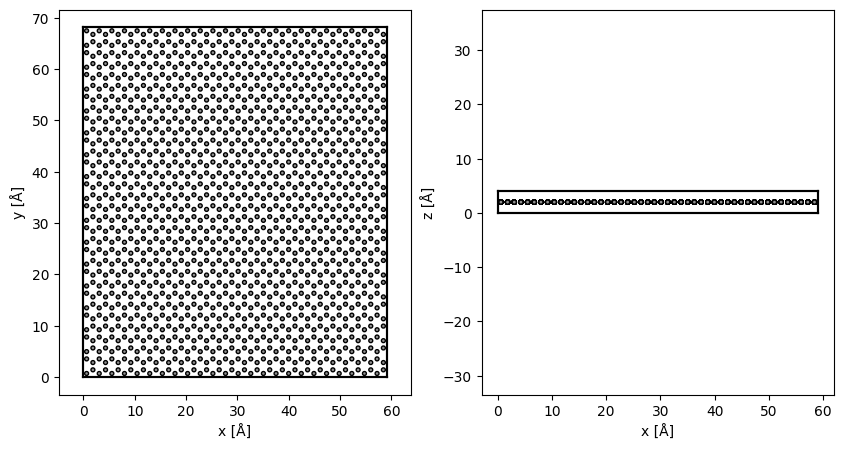

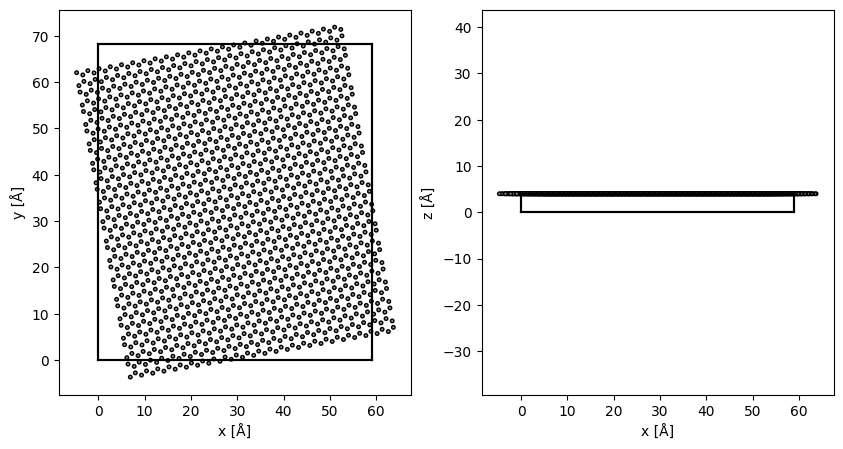

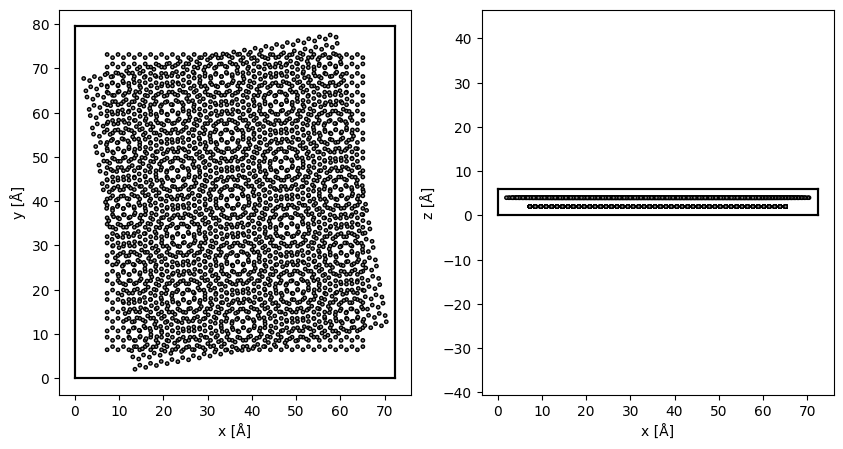

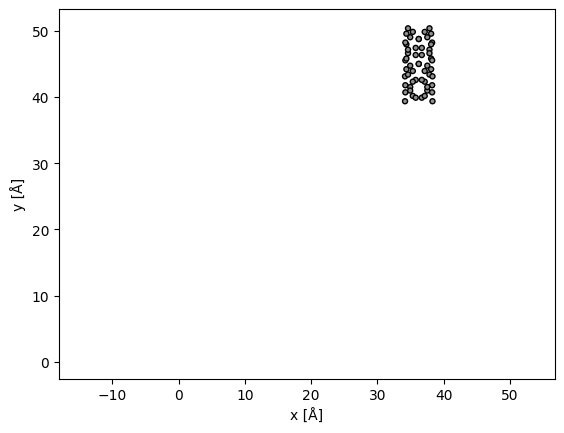

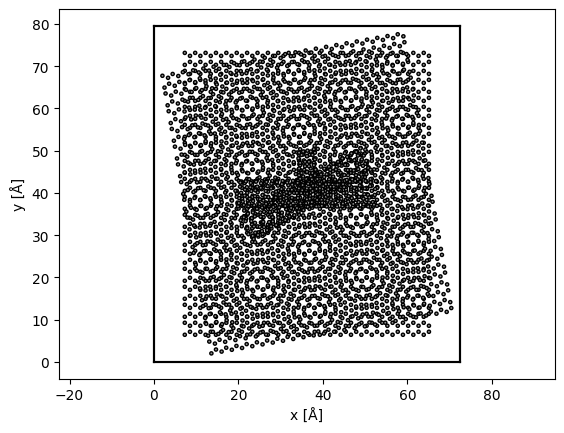

In [13]:
atoms = graphene()
atoms = orthogonalize_cell(atoms)
atoms *= (24,16,1)

atoms.center(vacuum=2, axis=2)
atoms.center()

fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
show_atoms(atoms, ax=ax1)
show_atoms(atoms, ax=ax2, plane='xz');
#
atoms_rotated=atoms.copy()
atoms_rotated.rotate(10,"z")
atoms_rotated.center()
atoms_rotated.positions+=np.array([0,0,2])
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
show_atoms(atoms_rotated, ax=ax1)
show_atoms(atoms_rotated, ax=ax2, plane='xz');
#
atoms_moire=atoms+atoms_rotated
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(10,5))
atoms_moire.center(vacuum=2)

show_atoms(atoms_moire, ax=ax1)
show_atoms(atoms_moire, ax=ax2, plane='xz')
#
cnt = nanotube(5, 4, length=1)
cnt.rotate(90,"y",center='COM')
cnt.center(vacuum=1,about=0)
#show_atoms(cnt,plane="xz")
cnt.translate(-cnt.get_center_of_mass()+atoms_moire.get_center_of_mass()+np.array([0,0,3.9]))

cnt2=cnt.copy()
cnt2.rotate(30,"z",center='COM')

cnt3 = nanotube(2, 4, length=1)
cnt3.translate(-cnt3.get_center_of_mass()+atoms_moire.get_center_of_mass()+np.array([0,5,3.9]))
cnt3.rotate(90,"x",center='COM')
#cnt3.rotate(60,"z",center='COM')
show_atoms(cnt3,plane="xy")
#
atoms_tot=atoms_moire+cnt+cnt2+cnt3
atoms_tot.center(vacuum=2)
show_atoms(atoms_tot)

atoms=atoms_tot

In [14]:
_,potential=get_potential_from_atoms(atoms, extent, sampling);

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7fe7d0b91a80>)

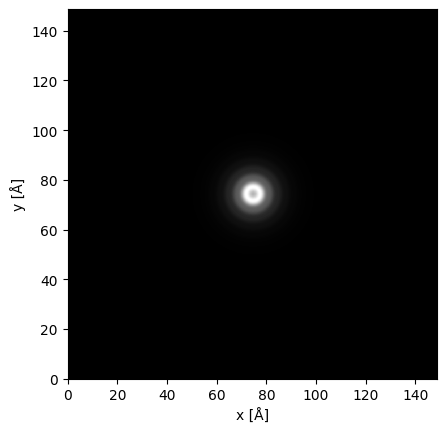

In [15]:
probe.show()

In [16]:
incoh_probe=incoherent_probe(probe,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma)                                                                                                                                                                                                                            
r, _, _, _= get_probe_radius(probe_measurement=incoh_probe,current_ratio=0.90)                                                                                                                                                                                                                                             
d=2*r
scan_extent = potential.extent[0]*4/6
scan_gpts = 16
#scan_sampling = scan_extent/scan_gpts
scan_sampling = 6
#scan_sampling = d*0.15/2#*np.random.uniform(0.15,0.5)                                                                                                                                                                                                                                                                        
positions=get_positions(scan_gpts,np.array(probe.extent),scan_sampling)                                                                                                                                                                                                                                                  
scan=PositionScan(positions=positions)

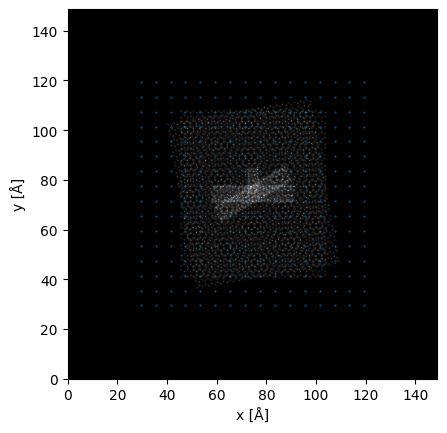

In [17]:
potential.build().project().show()
plt.plot(positions[:,0],positions[:,1],"x",markersize=1,alpha=0.5)

In [18]:
50e-12*1e-5/1.6e-19*60**2/150**2

500.00000000000006

In [19]:
d*0.15/2

2.3094051376803617

In [20]:
measurement_raw=probe.scan(scan,detectors=detector,potential=potential,max_batch=100,pbar=False)                                                                                                                                                                                                                       

measurement_=crop(measurement_raw,extent=(angular_semiextent*2,angular_semiextent*2))

In [21]:
norm=np.mean(np.sum(measurement_raw.array,(-2,-1))) # !uncropped! 
el=50e-12*1e-3/c.e 
measurement = poisson_noise(measurement_/norm, dose=el,pixel_area=1)/el 

(<Axes: title={'center': 'Slice (0,) of (256, 255, 255) measurement'}, xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7fe7bc41b670>)

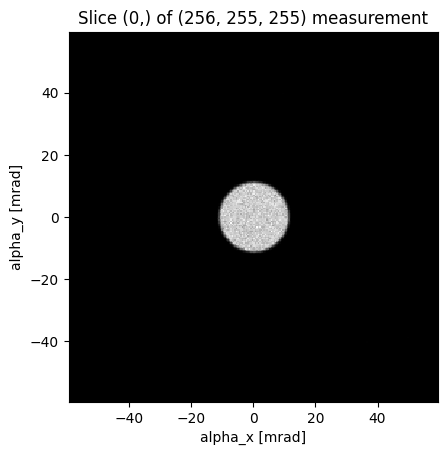

In [22]:
measurement.show()

In [23]:
probe_guess = Probe(semiangle_cutoff=semiangle_cutoff, energy=energy,defocus=defocus,C30=aberrations['C30'],extent=40,gpts=256)
reconstructions = invms(measurement, probe_guess, positions = positions, modes=1,k_modes=1, alpha=0.1, fac=1, beta=0.1, slices=1, slice_thickness=21,  maxiter=2, return_iterations=True, fix_com=True,device='gpu')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

probes norm:  [0.99178185] probes norm sum:  0.9917818532669351
SSE:  6.880629634323065e-11
probes norm:  [0.99432221] probes norm sum:  0.9943222079818793
SSE:  6.289052710340349e-11


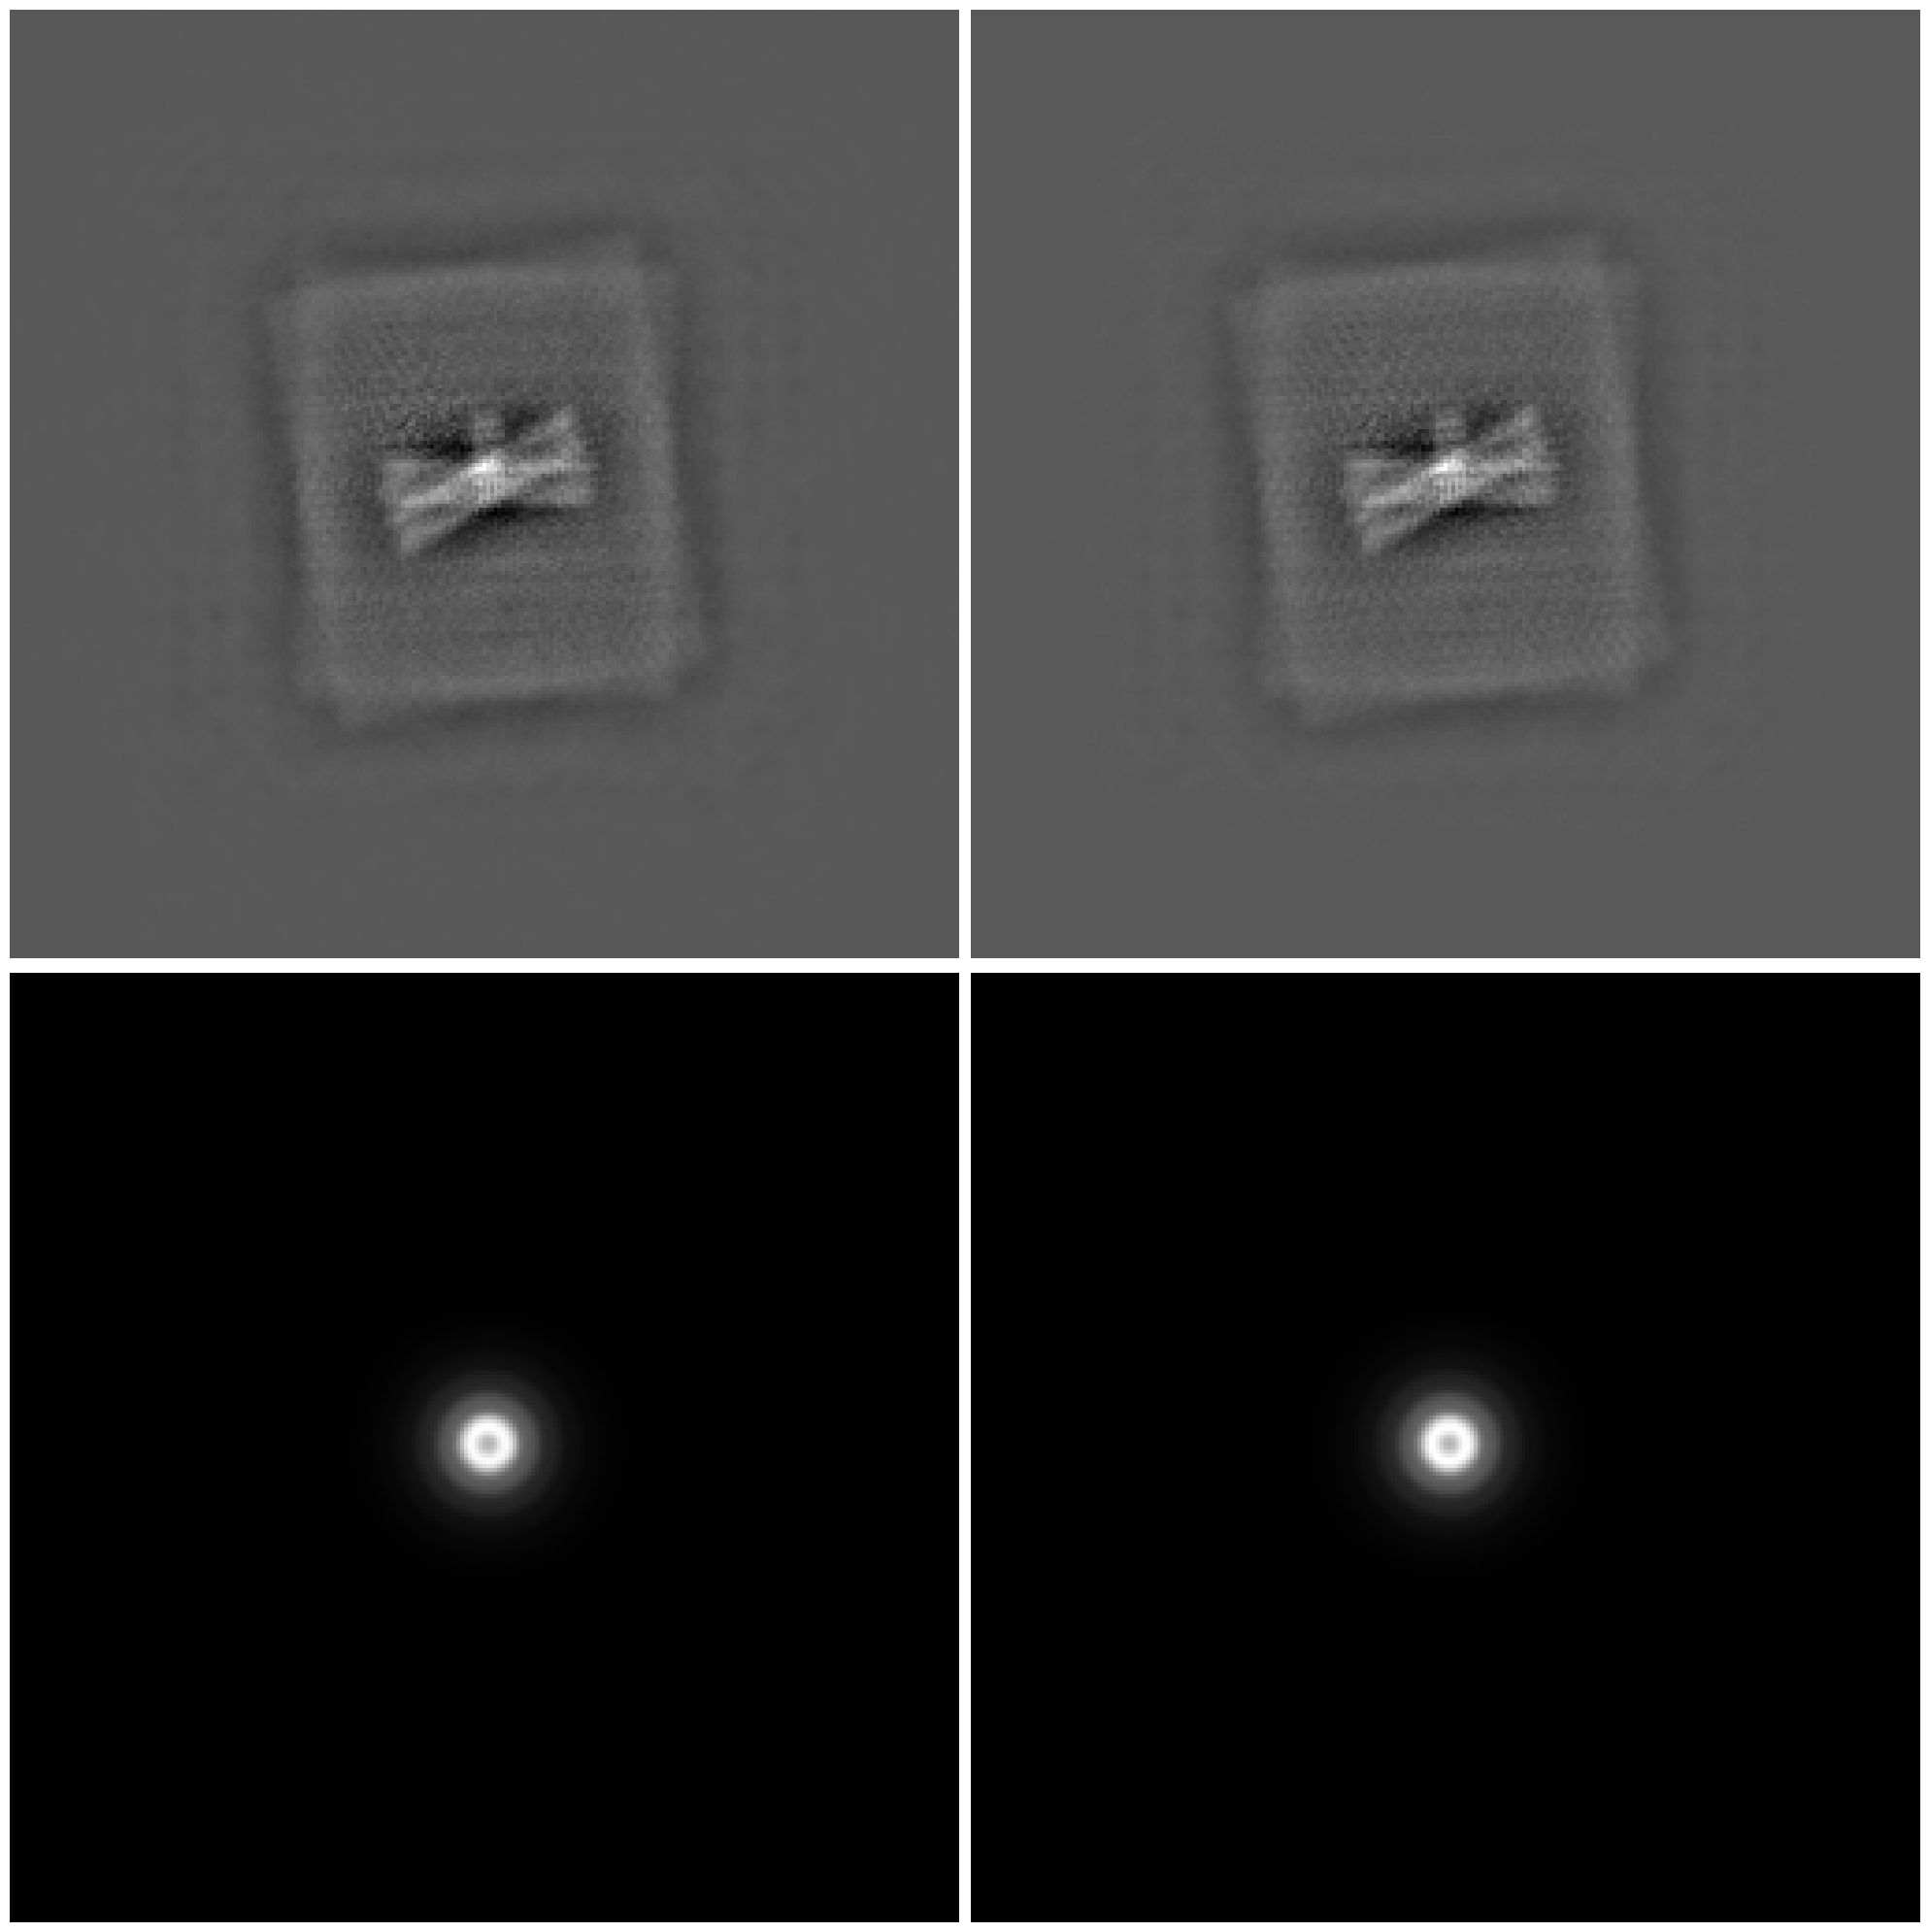

In [24]:
#%matplotlib inline
plot_every = 1

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions[0]) / plot_every)), figsize=(20,20))
for i, j in enumerate(range(0, len(reconstructions[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions[0][j][0].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions[1][j][0].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()

In [25]:
import py4DSTEM

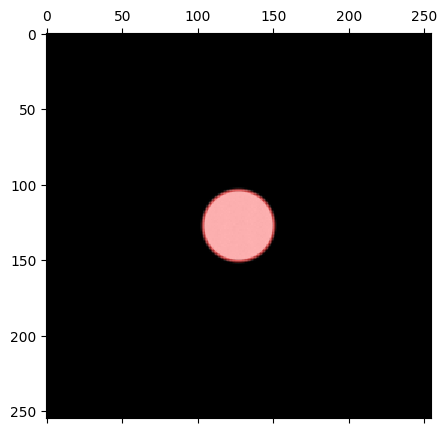

In [26]:
dataset = py4DSTEM.DataCube(measurement.array.reshape((scan_gpts,scan_gpts,*measurement.array.shape[-2:])))
dataset.get_dp_mean()
probe_radius_pixels, probe_qx0, probe_qy0 = dataset.get_probe_size(plot=True)

In [27]:
dataset.calibration.set_R_pixel_size(scan_sampling)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration.set_Q_pixel_size(semiangle_cutoff / probe_radius_pixels)
dataset.calibration.set_Q_pixel_units('mrad')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      0.5235509400892776
             R_pixel_size:      6
             Q_pixel_units:     mrad
             R_pixel_units:     A
             QR_flip:           False
             probe_semiangle:   23.684419319131607
             qx0_mean:          127.00139776163734
             qy0_mean:          126.99991213410242
)

In [28]:
probe.ctf.defocus

-400

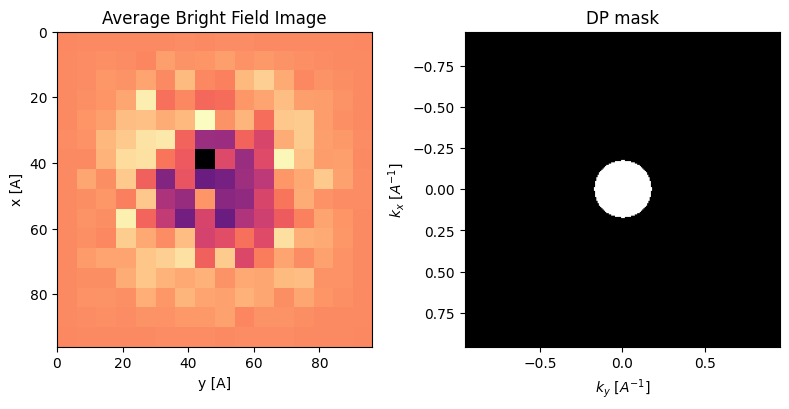

In [29]:
padding_px=16
parallax = py4DSTEM.process.phase.Parallax(
    datacube=dataset,
    energy = energy,
    object_padding_px=(padding_px,padding_px),
    device = "gpu",
    verbose=True,
).preprocess(
    normalize_images=True,
    plot_average_bf=True,
    edge_blend=8,
)

Alignment at bin 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:02<00:00, 147.63 image subsets/s]


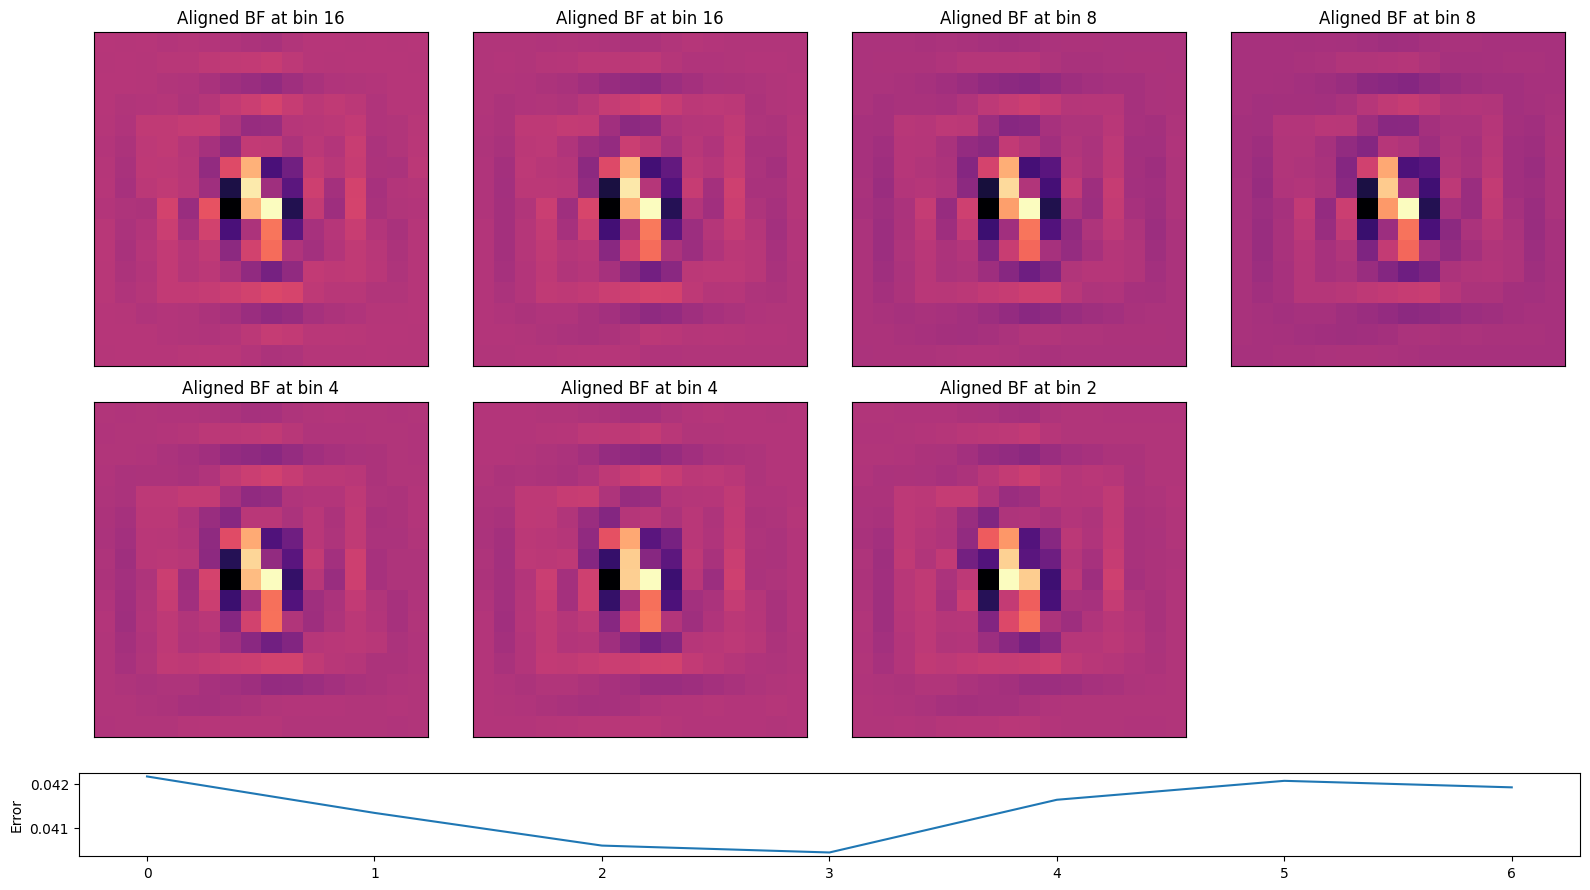

In [30]:
parallax = parallax.reconstruct(
    reset=True,
    regularizer_matrix_size=(4,4),
    regularize_shifts=True,
    running_average=True,
    alignment_bin_values = [16,16,8,8,4,4,2]#[32,32,16,16,8,8,8,8]
)

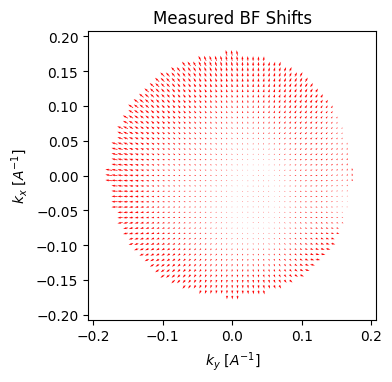

In [31]:
parallax.show_shifts(scale_arrows=0.4)

Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

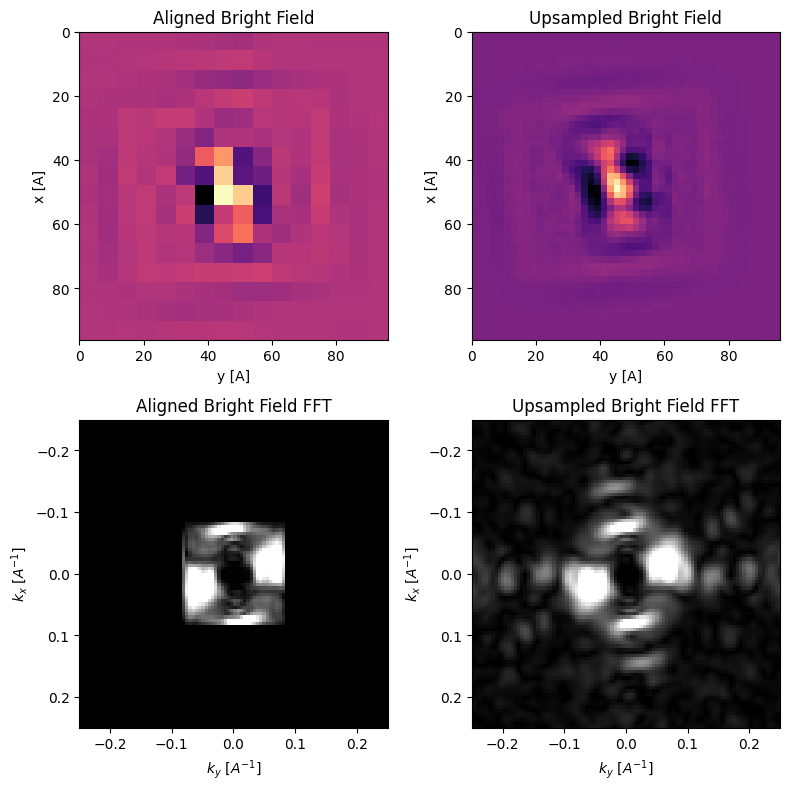

In [32]:
kde_upsample_factor=3
parallax.subpixel_alignment(
    kde_upsample_factor=kde_upsample_factor,
    kde_sigma_px=0.,
    plot_upsampled_BF_comparison=True,
    plot_upsampled_FFT_comparison=True,
)

In [33]:
aberrations["C30"]

8800000.0

Initial Aberration coefficients
-------------------------------
Rotation of Q w.r.t. R = -1.834 deg
Astigmatism (A1x,A1y)  = (1,-21) Ang
Aberration C1          =  910 Ang
Defocus dF             = -910 Ang
Transpose              = False

Refined Aberration coefficients
-------------------------------
aberration    radial   angular   dir.   coefs
name          order    order             Ang 
----------   -------   -------   ----   -----
C1              2        0         -      761
C3              4        0         -      1538610


Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

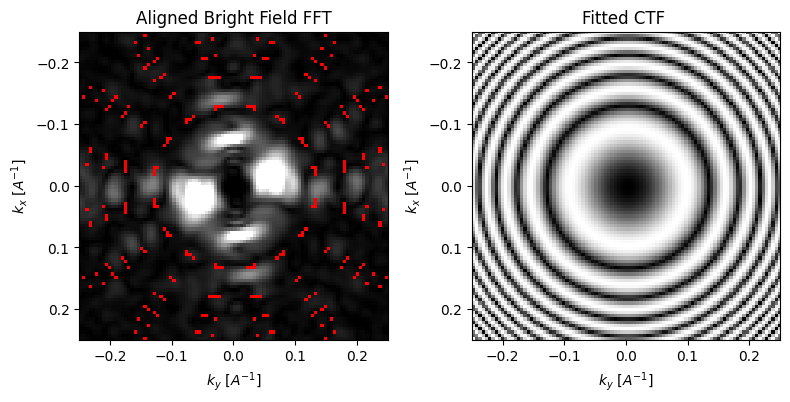

In [34]:
parallax.aberration_fit(
    #fit_CTF_FFT=True,
    fit_BF_shifts=True,
    plot_CTF_comparison=True,
    #fit_aberrations_max_radial_order=4,
    #fit_aberrations_max_angular_order=1,
    fit_aberrations_mn=np.array([[3,0,0],[1,0,0]]),
)

In [35]:
15e-3*(1/Probe(energy=30e3).wavelength)

0.2149279945142685

<Axes: xlabel='alpha [mrad]', ylabel='Envelope'>

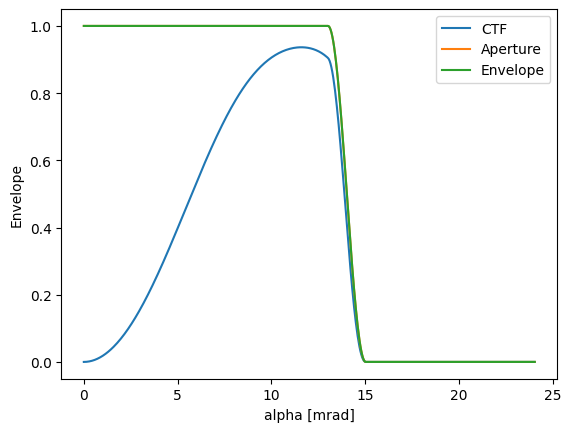

In [36]:
Probe(energy=30e3,C30=3e6,defocus=402,semiangle_cutoff=15).ctf.show()

<Axes: xlabel='alpha [mrad]', ylabel='Envelope'>

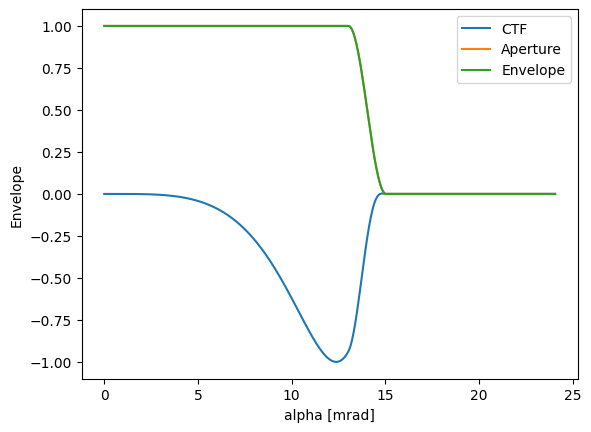

In [37]:
Probe(energy=30e3,C30=3e6,defocus=0,semiangle_cutoff=15).ctf.show()

In [38]:
scan_extent

99.25804863878294

Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

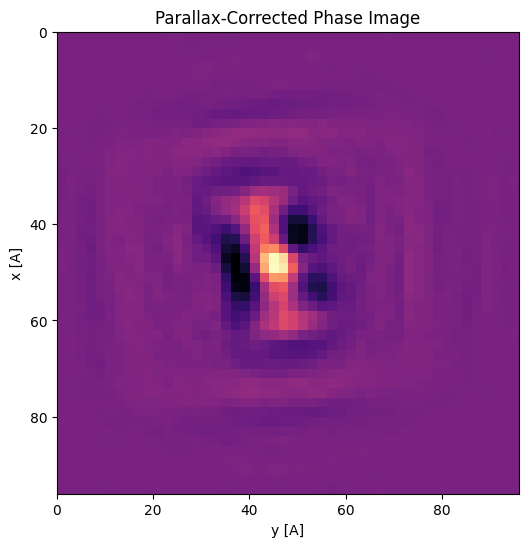

In [39]:
parallax.aberration_correct()

In [40]:
parallax.aberration_dict_polar

{'C10': 760.5954246202247, 'C30': 1538610.155632882}

In [41]:
1e-3*(1/Probe(energy=80e3).wavelength)/(1/Probe(energy=30e3).wavelength)

0.0016713496441091648

In [42]:
###############
#exporting:

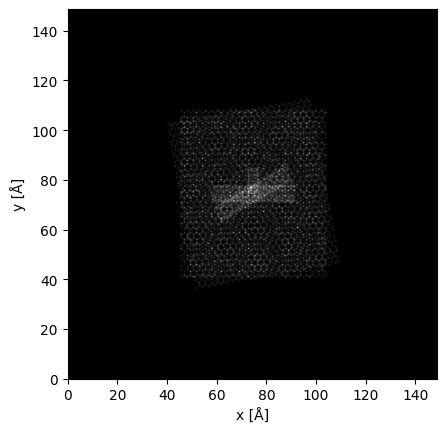

In [43]:
potential.project().show()
plt.savefig("figs_parallax/potential.pdf")

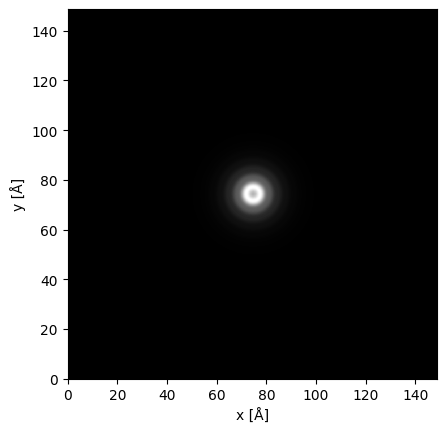

In [44]:
probe.show()
plt.savefig("figs_parallax/probe.pdf")

In [45]:
scan_extent=(0,scan_sampling*(scan_gpts+padding_px),0,scan_sampling*(scan_gpts+padding_px))

Text(0, 0.5, 'y [Å]')

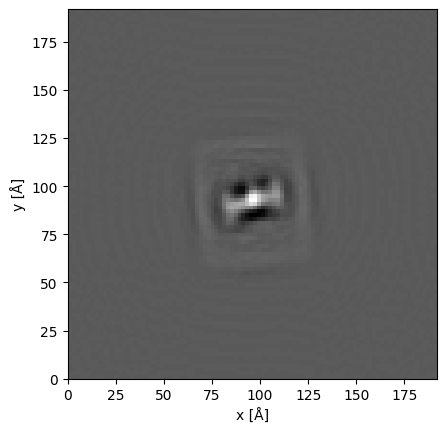

In [46]:
plt.imshow(parallax.recon_phase_corrected.T,extent=scan_extent,origin="lower",cmap="gray")
plt.xlabel("x [Å]")
plt.ylabel("y [Å]")
#plt.savefig("figs_parallax/recon_phase_corrected_upsampled_{}x.pdf".format(kde_upsample_factor))

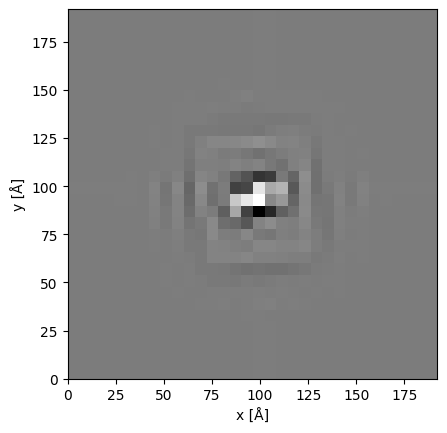

In [47]:
plt.imshow(parallax.recon_BF.T,extent=scan_extent,origin="lower",cmap="gray")
plt.xlabel("x [Å]")
plt.ylabel("y [Å]")
plt.savefig("figs_parallax/recon_BF.pdf")

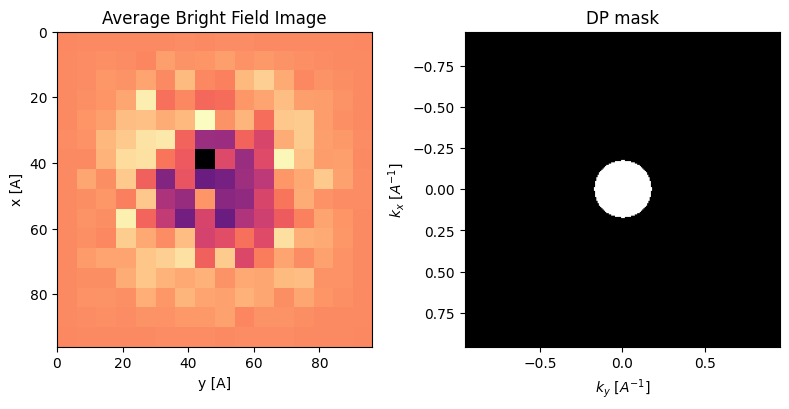

In [48]:
parallax_dummy = py4DSTEM.process.phase.Parallax(
    datacube=dataset,
    energy = energy,
    object_padding_px=(padding_px,padding_px),
    device = "gpu",
    verbose=True,
).preprocess(
    normalize_images=True,
    plot_average_bf=True,
    edge_blend=8,
)

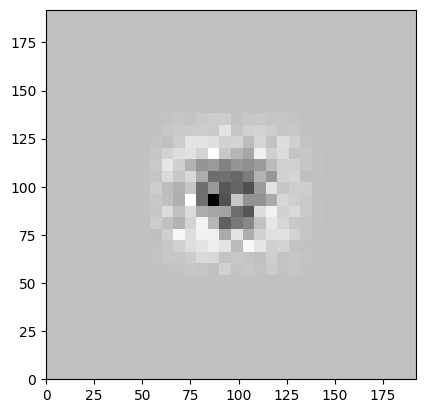

In [49]:
plt.imshow(parallax_dummy.recon_BF.T,extent=scan_extent,origin="lower",cmap="gray")
plt.savefig("figs_parallax/recon_BF_uncorrected.pdf")

In [50]:
np.shape(parallax_dummy.recon_BF.T)

(32, 32)

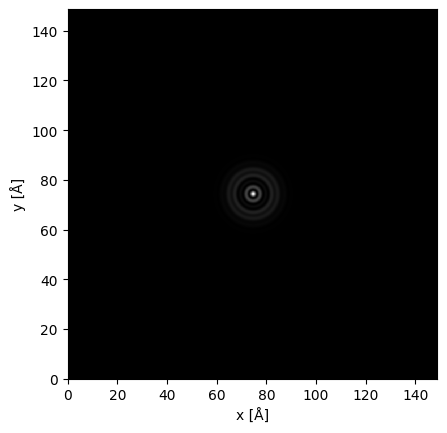

In [51]:
Probe(energy=energy,defocus=2042,semiangle_cutoff=18.0,C30=aberrations["C30"],C50=aberrations["C50"],extent=extent,sampling=sampling).show()
plt.savefig("ptycho_semi18.0_defocus2042_detectorsemi60.pdf")